# Analyse en composantes principales normée *From scratch*

Ce notebook a pour objectif d'effectuer une analyse en composantes principales normée construite **from scratch**. Mais aussi d'interpréter les résultats et les comparer avec les outils implémentés de Python qui permettent de réaliser le même travail.

Le but est de comprendre les diffentes étapes d'une ACP normée, comment interpréter les résultats obtenus et ... de s'amuser.

### Bonne Lecture ! 

In [17]:
# ACP avec python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Fichier de données et but du jeu 

On va travailler sur un fichier de températures dans différentes villes en Europe (35 en tout) et le but du travail ? Réduire la dimension du jeu de données tout en conservant un maximum d'informations (80% ou plus) du jeu de données initial.
Les variables qui vont nous intéresser(12 en tout) ici sont les différents mois de l'année durant lesquelles ont été relevées des températures moyennes (variables continues).

In [23]:
 df = pd.read_csv ("Temperatures.csv")
temperatures = df.iloc[:, 1:13].copy()

#Extraction des temperatures moyennes mensuelles sur les 35 villes
temperatures_array = np.array(temperatures, dtype=np.float64)

desc_stats = stats.describe(temperatures_array, axis = 0)

# Histoire que ce soit plus élégant comme rendu
rows = []
for i, col in enumerate(temperatures.columns):
    desc = stats.describe(temperatures_array[:, i])
    rows.append({
        'N': desc.nobs,
        'Min': desc.minmax[0],
        'Max': desc.minmax[1],
        'Mean': round(desc.mean, 2),
        'Variance': round(desc.variance, 2)
    })

summary_df = pd.DataFrame(rows, index=temperatures.columns)
summary_df


,N,Min,Max,Mean,Variance
Janvier,35,-9.3,10.7,1.35,30.27
Fevrier,35,-7.9,11.8,2.22,30.24
Mars,35,-3.7,14.1,5.23,23.65
Avril,35,2.9,16.9,9.28,14.49
Mai,35,6.5,20.9,13.91,10.72
Juin,35,9.3,24.5,17.41,11.02
Juillet,35,11.1,27.4,19.62,12.78
Aout,35,10.6,27.2,18.98,13.90
Septembre,35,7.9,24.3,15.63,16.89
Octobre,35,4.5,19.4,11.00,18.69


## Centrage et réduction des données

Comme on va faire une ACP normée, il va falloir pour chaque mois centrer et réduire les données.
Pour cela, j'ai opté utiliser la fonction scale_matrix qui centre et réduit chaque colonne d'une matrice X donnée

In [25]:
# Retourne une matrice centrée et réduite de la matrice de départ X
def scale_matrix (X) :
    
    n, p = X.shape
    scaled_matrix = np.zeros((n, p), dtype="float64")
    
    for i in range (p) :
        meanX, stdX = X[:, i].mean(), X[:, i].std(ddof=1)
        scaled_matrix[:, i] = (X[:, i] - meanX)  / stdX
        
    return scaled_matrix

In [26]:
scaled_matrix = scale_matrix (temperatures_array)
print (scaled_matrix[:5, :5]) # Extrait de la matrice centrée et réduite

[[ 0.28248662  0.05143833  0.09694112 -0.28447907 -0.4311573 ]
 [ 1.40931743  1.36077769  1.33073722  1.60704404  1.89045892]
 [-0.28092879 -0.38500812 -0.17038137 -0.28447907 -0.03403873]
 [ 0.35518538  0.19692048  0.30257381 -0.10058099 -0.33951455]
 [-0.444501   -0.25771124  0.05581459  0.60874018  0.94348388]]


Une fois centrée et réduite, on peut facilement calculer la matrice de corrélation à l'aide de la formule : 
$$
\frac{1}{n-1} X^\top X
$$
Ce calcul est effectué par la fonction **correlation_matrix**

In [27]:
# Calcul de la matrice de corrélation
# M est une matrice centrée et réduite par la fonction scale_matrix
def correlation_matrix (M) : 
    n =  M.shape[0]
    return (1/ (n-1)) * np.dot (M.T, M)

In [28]:
corr_mat = correlation_matrix (scaled_matrix)
print (corr_mat[:5, :5])

[[1.         0.9900015  0.95584383 0.83129992 0.63578025]
 [0.9900015  1.         0.97925345 0.88041972 0.69237412]
 [0.95584383 0.97925345 1.         0.94542952 0.79591065]
 [0.83129992 0.88041972 0.94542952 1.         0.94340233]
 [0.63578025 0.69237412 0.79591065 0.94340233 1.        ]]


Donc une fois que c'est fait, on a les différents axes factoriels qui sont là et il faut choisir.
Le choix se fera d'après le **critère de variance cumulée** dont plus de 80 % d'inertie pour toutes les axes choisis.

In [29]:
# Contribution de chaque axe et graphe
eigenvalues = np.array (np.linalg.eig (corr_mat)[0])
eigenvectors = np.array (np.linalg.eig (corr_mat)[1])
contributions = eigenvalues / sum(eigenvalues)
contributions

array([8.68704413e-01, 1.14208231e-01, 1.00423024e-02, 3.52774838e-03,
       1.91023370e-03, 7.23686143e-04, 3.48171998e-04, 2.44193714e-04,
       1.22979151e-04, 3.14343474e-05, 6.55244122e-05, 7.10811041e-05])

On peut constater que le 1er axe cumule à lui seul plus de 80% de l'inertie totale. Donc on pourrait s'arrêter là. Mais je veux tout de même rajouter le second axe car on aura encore plus d'inertie et c'est tant mieux.

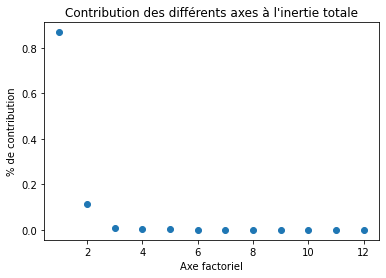

In [32]:
plt.scatter (np.arange(1, 13), contributions)
plt.title("Contribution des différents axes à l'inertie totale")
plt.xlabel("Axe factoriel")
plt.ylabel("% de contribution")
plt.show()

In [33]:
# Coordonnées des individus dans les composantes principales
coordonnees_axe = np.dot (scaled_matrix, eigenvectors)
print (coordonnees_axe[:5, :5])

[[ 5.44406866e-01 -1.23241284e+00 -2.35324633e-02 -1.09971438e-01
  -3.43024189e-01]
 [-6.19349616e+00  9.44437381e-01 -5.16933398e-01 -2.98318480e-01
   5.33002796e-03]
 [ 1.00365512e+00  3.15721842e-02  2.02263644e-01  5.35933321e-02
  -2.34663558e-01]
 [ 1.72422405e-01 -1.05070563e+00  3.98905964e-02  8.84139173e-02
  -1.41452157e-01]
 [-7.86543225e-01  1.58932143e+00  4.84671543e-01  9.65905012e-02
   9.71132614e-03]]


## Représentation des individus dans les plans factoriels

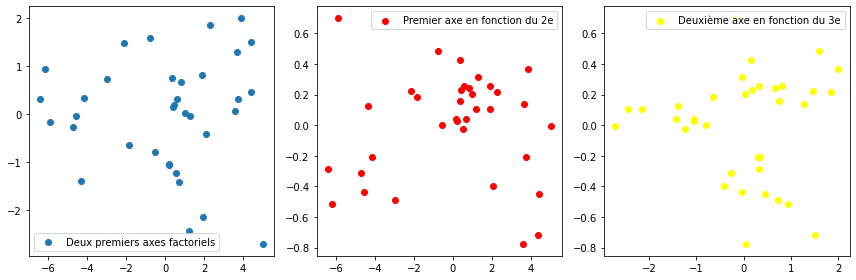

In [34]:
# Représentation des individus dans les plans factoriels
x = np.linspace (0, 2*np.pi, 100)
cosx = np.cos(x)
sinx = np.sin(x)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter (coordonnees_axe[:, 0], coordonnees_axe[:, 1], label = "Deux premiers axes factoriels")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter (coordonnees_axe[:, 0], coordonnees_axe[:, 2], color='red', label = "Premier axe en fonction du 2e")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter (coordonnees_axe[:, 1], coordonnees_axe[:, 2], color='yellow', label = "Deuxième axe en fonction du 3e")
plt.legend()


plt.tight_layout()
plt.show()

## Contribution et qualité de représentation des individus sur les 3 premiers axes

In [40]:
# Contribution et qualité de représentation des individus
n, p = coordonnees_axe.shape[0], 3
contribution_individus = np.zeros((n, p))
cos2_axes = np.zeros((n, p))
for k in range (3) :
    
    # Contribution de l'individu à l'axe k
    contribution_individus[:, k] = (coordonnees_axe[:, k] ** 2) / ((n-1) * eigenvalues[k])
    
    # Qualité de représentation de chaque individu sur l'axe k
    cos2_axes[:, k] = (coordonnees_axe[:, k]) ** 2 / np.sum(coordonnees_axe[:, 0:3]**2)



In [42]:
for k in range(3):
    pos_max_CTR = np.argmax(contribution_individus[:, k])
    pos_max_cos2 = np.argmax(cos2_axes[:, k])
    cos2_ind = cos2_axes[pos_max_cos2, k]
    contribution = contribution_individus[pos_max_CTR, k]
    print(f"Axe factoriel {k+1}:")
    print("*** Contribution")
    print(f"  - Position de l'individu : {pos_max_CTR}")
    print(f"  - Contribution : {np.round(contribution, 3)}\n")
    
    print("*** Qualité de représentation")
    print(f"  - Position de l'individu : {pos_max_cos2}")
    print(f"  - Qualité de représentation : {np.round(cos2_ind, 3)}\n")


Axe factoriel 1:
*** Contribution
  - Position de l'individu : 32
  - Contribution : 0.116

*** Qualité de représentation
  - Position de l'individu : 32
  - Qualité de représentation : 0.102

Axe factoriel 2:
*** Contribution
  - Position de l'individu : 18
  - Contribution : 0.158

*** Qualité de représentation
  - Position de l'individu : 18
  - Qualité de représentation : 0.018

Axe factoriel 3:
*** Contribution
  - Position de l'individu : 22
  - Contribution : 0.148

*** Qualité de représentation
  - Position de l'individu : 22
  - Qualité de représentation : 0.002



Coordonnées des variables et leur qualité de représentation ainsi que leur contribution dans les différents axes considérés (1, 2 & 3)

In [53]:
m, q = (3, 12)
coordonnees_variables = np.zeros((m, q))
for k in range (p) : 
    coordonnees_variables[k, :] = eigenvectors[k, :] * np.sqrt (eigenvalues[k])
print (coordonnees_variables)

[[-0.88607553 -1.2618043  -0.48421791 -0.1818102   0.6640284   0.74152849
   1.55005459 -0.53965574 -0.30156317  1.45912315 -1.23326592 -0.59500402]
 [-0.33198315 -0.39031905  0.06526332  0.30337098  0.55652194 -0.24430577
   0.15232987  0.27413497  0.06559142 -0.03507555  0.45748576  0.57363896]
 [-0.1030464  -0.07317738  0.09436133  0.1679448  -0.02457933  0.09313679
  -0.09368503 -0.1258242   0.1194412  -0.03329791  0.05740025 -0.12193302]]


In [ ]:
# Contribution et qualité de représentation des individus
contribution_variables = np.zeros((m, q))
cos2_variables = np.zeros((m, q))
for k in range (3) :
    
    # Contribution de l'individu à l'axe k
    contribution_variables[:, k] = (coordonnees_variables[:, k] ** 2) / ((n-1) * eigenvalues[k])
    
    # Qualité de représentation de chaque individu sur l'axe k
    cos2_axes[:, k] = (coordonnees_axe[:, k]) ** 2 / np.sum(coordonnees_axe[:, 0:3]**2)